# Road Network Analysis And Optimization

### **Road Optimization Study for Gazi Street in Elazığ City Center**

Gazi Street, located in the city center of Elazığ, is a critical area for transportation due to its heavy traffic flow and the lack of alternative routes. In this study, without using current traffic data, the goal is to reduce the traffic load on Gazi Street by adding new alternative roads. The open spaces, existing roads, and connection points in the area will be analyzed to determine the most suitable routes that can be integrated into the main arteries. By adding new roads, the aim is to create a more balanced traffic flow, reduce travel times, and make urban transportation more efficient. In this context, alternative routes will be planned to determine where they can be added, which points will be connected, and how traffic congestion can be distributed, ultimately creating a sustainable road optimization for the Gazi Street area.


## Required Libraries Installation 

In [742]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [743]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [744]:
pip install osmnx

Note: you may need to restart the kernel to use updated packages.


In [745]:
pip install networkx

Note: you may need to restart the kernel to use updated packages.


In [746]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [747]:
pip install python-louvain

Note: you may need to restart the kernel to use updated packages.


In [748]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [749]:
pip install scipy


Note: you may need to restart the kernel to use updated packages.


In [750]:
pip install python-louvain


Note: you may need to restart the kernel to use updated packages.


## Importing Libraries Into The Project

In [752]:
import osmnx as ox
import networkx as nx
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from community import community_louvain
import folium
from folium.plugins import MarkerCluster
from folium.plugins import Fullscreen
from folium.plugins import MiniMap ,MousePosition
import plotly.graph_objects as go
from scipy.stats import entropy

## Fetching City Road Networks

In [754]:
# The coordinates of Elazığ (Gazi Street)
gazi_lat, gazi_lon = 38.6754194, 39.2153528

# Creating the road network graph for Gazi Street
G = ox.graph_from_point((gazi_lat, gazi_lon), dist=1500, dist_type = 'network' , network_type="drive" , retain_all = False , truncate_by_edge = False)
#osmnx.graph.graph_from_point(center_point, dist, *, dist_type='bbox' 'network', network_type={“all”, “all_public”, “bike”, “drive”, “drive_service”, “walk”} , simplify=True, retain_all=False, truncate_by_edge=False, custom_filter=None)

#Get the nodes
gazi_nodes = list(G.nodes())

# Get the edges
gazi_edges = list(G.edges())

print("The road network for Gazi Street has been created.")
print(f"Total number of nodes: {len(gazi_nodes)}")
print(f"Total number of edges: {len(gazi_edges)}")
print(f"Graph type: {type(G)}")


#print("\n Gazi Street Node Lists:")
#print ("gazi_nodes")

#print("\n Gazi Street  Edge Lists:")
#print ("gazi_edges")


The road network for Gazi Street has been created.
Total number of nodes: 955
Total number of edges: 2645
Graph type: <class 'networkx.classes.multidigraph.MultiDiGraph'>


- **955 Nodes:** These are intersections, road points, or connection points in the road network.
- **2645 Edges:** These are the road connections between nodes. Each edge represents a road segment.
- **MultiDiGraph:** A multi-directional, directed graph structure. The same two nodes can have multiple roads between them, meaning the roads can be bidirectional.


## Graph Visualization Of City Road Networks

In [758]:
# Creating map
m = folium.Map(location=[agri_lat, agri_lon], zoom_start=13)

# TileLayer
folium.TileLayer(
    tiles='https://tiles.stadiamaps.com/tiles/alidade_satellite/{z}/{x}/{y}{r}.{ext}',
    attr='Stadia Maps',
    name='Satellite',
    ext='png'
).add_to(m)

#Group the nodes using MarkerCluster
marker_cluster = MarkerCluster().add_to(m)

#Add the nodes to the map
for node, data in G.nodes(data=True):
    folium.Marker(
        location=[data['y'], data['x']],
        popup=f"Node: {node}",
        icon=folium.Icon(color="blue", icon="flag")
    ).add_to(marker_cluster)

#Extract the road geometries (edges) nx -> geodataframe
edges_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True)

#Add the roads to the map
for _, row in edges_gdf.iterrows():
  
    line = row['geometry']
    
    
    road_length = row['length']
    
   
    road_type = row.get('highway', 'Unknown')
    
   
    if isinstance(road_type, list):
        road_type = ', '.join(road_type)
    
   
    lat_lon_u = (line.coords[0][1], line.coords[0][0])  # Start point
    lat_lon_v = (line.coords[-1][1], line.coords[-1][0])  # End point
    
   
    popup_content = f"""
    <strong>Road Information</strong><br>
    <b>Connection Points:</b><br>
    Point ({lat_lon_u}) - Point ({lat_lon_v})<br><br>
    <b>Road Length:</b> {road_length:.2f} m<br>
    <b>Road Type:</b> {road_type.capitalize()}<br>
    """
    
    # Add the road geometry to the map
    folium.PolyLine(
        locations=[(lat, lon) for lon, lat in line.coords],
        color="red", 
        weight=4,     
        opacity=0.7
    ).add_to(m).add_child(folium.Popup(popup_content, max_width=300))

folium.plugins.Fullscreen(
    position="topright",
    title="Expand me",
    title_cancel="Exit me",
    force_separate_button=True,
).add_to(m)

folium.plugins.MiniMap(toggle_display=True).add_to(m)



formatter = "function(num) { return num.toFixed(6); }" 
folium.plugins.MousePosition(
    position="topright",
    separator=" | ",
    empty_string="NaN",
    lng_first=True,
    num_digits=6,  # 6 haneli hassasiyet
    prefix="Coordinates: ",
    lat_formatter=formatter,
    lng_formatter=formatter
).add_to(m)


layer_right = folium.TileLayer('Stamen Terrain')
layer_left = folium.TileLayer('OpenStreetMap')
sbs = folium.plugins.SideBySideLayers(layer_left=layer_left, layer_right=layer_right)
layer_left.add_to(m)
layer_right.add_to(m)
sbs.add_to(m)


m


# Degree Centrality 


Degree Centrality is a simple and widely used network centrality measure that quantifies the number of connections a node has to other nodes in a network. This measure helps determine how central a node is in the network and how many connections it has to other nodes.

#### How is Degree Centrality Calculated?

- **In Undirected Networks**: The degree centrality of a node is determined by the number of edges connected to that node.

  $$
  C_D(v) = \frac{\text{Number of connections (degree)}}{\text{Total number of nodes} - 1}
  $$

  Where:
  - $C_D(v)$ is the degree centrality of node $v$,
  - The number of connections is the number of edges connected to the node,
  - The total number of nodes is the total number of nodes in the network.

- **In Directed Networks**: Degree centrality can be calculated separately for incoming connections (in-degree) and outgoing connections (out-degree).

  - For incoming connections:

  $$
  C_D(v)_{\text{in}} = \frac{\text{Number of incoming edges}}{\text{Total number of nodes} - 1}
  $$

  - For outgoing connections:

  $$
  C_D(v)_{\text{out}} = \frac{\text{Number of outgoing edges}}{\text{Total number of nodes} - 1}
  $$

#### Meaning of Degree Centrality

- **High Degree Centrality**: A node with more connections in the network is considered more central. This means it has more influence or control within the network.

- **Low Degree Centrality**: A node with fewer connections in the network is more isolated, and its influence in the network is limited.


In [761]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)


#print("Degree Centrality for each node:")
#for node, centrality in degree_centrality.items():
    #print(f"Node {node}: {centrality}")


In [762]:
# Sort the nodes in descending order according to degree centrality
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

#print("Degree Centrality for each node (sorted):")
#for node, centrality in sorted_degree_centrality:
    #print(f"Node {node}: {centrality}")

In [763]:
# Ağda her bir bağlantı sayısı için düğüm sayısını hesaplar.
degree = nx.degree_histogram(G) 

# Ağdaki her derecenin yüzdesini hesaplar
perc_degree = [((d * 100) / G.number_of_nodes()) for d in degree] 

# Bu, derece değerlerinin aralığını oluşturur
deg_domain = list(range(0, len(degree)))  

# Plotly figürünü oluşturur
fig = go.Figure()

# Veriyi figüre ekler
fig.add_trace(go.Scatter(
    x=deg_domain, 
    y=perc_degree,
    mode='lines+markers',
    name=f'Degree Distribution Gazi Street',
    line=dict(width=2),  
    marker=dict(size=6)  
))

# Layout ayarlarını yapar
fig.update_layout(
    title=f"Degree Distribution Gazi Street",
    xaxis_title="Degree",
    yaxis_title="Percentage of Nodes (%)",
    showlegend=True,
    template="plotly_dark", 
    hovermode='closest'
)


fig.show()


degree_data = {
    "Degree" : deg_domain , 
    "Percentage of Nodes" : perc_degree
}

df = pd.DataFrame(degree_data)
print(df)

   Degree  Percentage of Nodes
0       0             0.000000
1       1             0.104712
2       2             4.921466
3       3             5.654450
4       4            19.057592
5       5             1.047120
6       6            54.031414
7       7             0.104712
8       8            15.078534


### Degree Centrality Entropy

In general, entropy measures the uncertainty or disorder in a system. In the context of network analysis, entropy helps us understand the diversity and disorder in the distribution of connections in a network. High entropy typically indicates that the centrality of nodes is unevenly distributed in the network. In this case, some nodes may be more central, while others may be more isolated. On the other hand, low entropy indicates that the degree distribution in the network is more homogeneous. In such a network, all nodes may have similar degrees, and there is no distinct centralization. In this type of network, the connection numbers of the nodes are close to each other, and the network exhibits a more ordered structure.

#### Entropy Calculation Formula:

Entropy is calculated using the following formula:

$$
H(X) = - \sum_{i=1}^{n} p_i \log(p_i)
$$

- $H(X)$: Entropy value
- $p_i$: The probabilities of each degree (i.e., the proportion of nodes with a certain degree in the network)
- $n$: Number of nodes or degree types

According to this formula, the more variety and disorder there is, the higher the entropy value will be.


In [766]:
total_nodes = G.number_of_nodes()

degree_probabilities = [count / total_nodes for count in degree]

entropy = -np.sum(np.array(degree_probabilities) * np.log2(np.array(degree_probabilities) + 1e-9))

print(f"Degree Distribution Entropy: {entropy}")


Degree Distribution Entropy: 1.8849799787985106


The entropy value I calculated for my network is 1.88498, which indicates that the degree distribution of my network has a high level of diversity and that there is noticeable disorder and inequality within the network. High entropy means that the number of connections between the nodes in the network varies significantly, meaning my network is disordered. This suggests that some nodes have many connections, while others have very few. This type of structure indicates the presence of central nodes in my network, but it also shows that many nodes are isolated. Since the diversity of connections is high, centralization in my network is not spread evenly and is more imbalanced. This suggests that my network has a complex structure with a significant inequality between the nodes.

# Closeness Centrality

### Closeness Centrality

Closeness Centrality is a centrality measure that represents the inverse of the average shortest distance from a node to all other nodes in the network. This metric shows how quickly and directly a node can access other nodes in the network. In other words, the shorter the paths a node has to other nodes, the higher its closeness centrality value. This indicates that the node holds a more central position in terms of information flow or accessibility.

Closeness Centrality is calculated using the following formula:

$$
C_C(v) = \frac{n - 1}{\sum_{u \neq v} d(v, u)}
$$

Where:

- $C_C(v)$ is the closeness centrality value of node $v$,
- $d(v, u)$ is the shortest path distance from node $v$ to node $u$,
- $n$ is the total number of nodes in the network.

This formula calculates the total distance from a node to all others and takes the inverse of that sum. Therefore, nodes with shorter total distances to other nodes will have higher closeness centrality values.


In [770]:
# Calculate closeness centrality 
closeness_centrality = nx.closeness_centrality(G)


#print("Closeness Centrality for each node:")
#for node, value in closeness_centrality.items():
    #print(f"Node {node}: {value:.4f}")

In [771]:

sorted_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

#print("\nNodes sorted by Closeness Centrality (Descending):")
#for node, value in sorted_closeness:
    #print(f"Node {node}: {value:.4f}")


In [772]:
closeness_values = list(closeness_centrality.values())

closeness_stats = {
    'Min': np.min(closeness_values),
    '1st Quartile': np.percentile(closeness_values, 25),
    'Median': np.median(closeness_values),
    '3rd Quartile': np.percentile(closeness_values, 75),
    'Max': np.max(closeness_values),
    'Mean': np.mean(closeness_values),
}

print("Closeness Centrality Statistics:")
for stat, value in closeness_stats.items():
    print(f"{stat}: {value:.4f}")

Closeness Centrality Statistics:
Min: 0.0276
1st Quartile: 0.0423
Median: 0.0481
3rd Quartile: 0.0553
Max: 0.0716
Mean: 0.0491


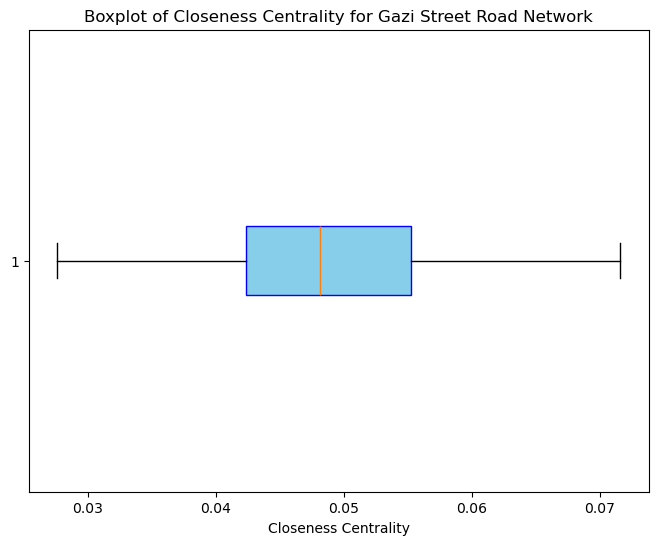

In [773]:


plt.figure(figsize=(8,6))
plt.boxplot(closeness_values, vert=False, patch_artist=True, boxprops=dict(facecolor="skyblue", color="blue"), 
            flierprops=dict(markerfacecolor='red', marker='o', markersize=6, linestyle='none'))
plt.title("Boxplot of Closeness Centrality for Gazi Street Road Network")
plt.xlabel("Closeness Centrality")
plt.show()


The lowest Closeness Centrality value of 0.0276 indicates that some nodes in my network take longer paths to reach other nodes. These nodes might be isolated or located at more distant points in the network. On the other hand, the number of nodes in my network that are in central positions is also significant. The difference between the first quartile value of 0.0423 and the third quartile value of 0.0553 shows that some nodes in my network are much more central than others. This suggests that there are more central nodes in my network. The median value of 0.0481 reveals that most nodes in my network have an average centrality. The mean value of 0.0491 suggests that there is no major disparity between nodes, and overall, centrality is fairly evenly distributed. The highest Closeness Centrality value of 0.0716 indicates that there is a highly central node in my network, which can reach all other nodes the fastest.

# Community

Modularity is used to determine the structural integrity of a network and how nodes can cluster together. In a network, communities have many connections between the nodes within the community, while there are fewer connections between communities. Modularity helps to identify these types of structures.

### How is Modularity Calculated?
Modularity measures how strongly the communities in a network are connected to each other. The modularity value is calculated as follows:

$$
Q = \frac{1}{2m} \sum_{i,j} \left( A_{ij} - \frac{k_i k_j}{2m} \right) \delta(c_i, c_j)
$$

Where:

- $Q$ represents the modularity value.
- $A_{ij}$ shows the actual connection between two nodes. That is, $A_{ij} = 1$ if there is a connection between node $i$ and node $j$, and $A_{ij} = 0$ if there is no connection.
- $k_i$ and $k_j$ represent the degrees (number of connections) of node $i$ and node $j$, respectively.
- $m$ is the total number of edges (connections) in the network.
- $\delta(c_i, c_j)$ is a function that indicates whether nodes $i$ and $j$ belong to the same community. If they belong to the same community, $\delta(c_i, c_j) = 1$, otherwise, it is 0.

### High vs. Low Modularity:
- **High Modularity**: High modularity indicates that there are clear community structures within the network, and most nodes have strong connections within their communities. This means that the network has distinct communities with less inter-community connection.
- **Low Modularity**: Low modularity suggests that the network is more homogeneous, with fewer distinct communities. This implies that there are not many clear divisions in the network, and the nodes are more evenly connected across the network


In [778]:
# Converting the directed graph to an undirected graph
G_undirected = G.to_undirected()

# Detecting communities using the Louvain method
partition = community_louvain.best_partition(G_undirected)

# Calculating the modularity value
modularity = community_louvain.modularity(partition, G_undirected)

# Printing the results
print(f"Modularity for Gazi Street: {modularity}")


Modularity for Gazi Street: 0.8556344556382197


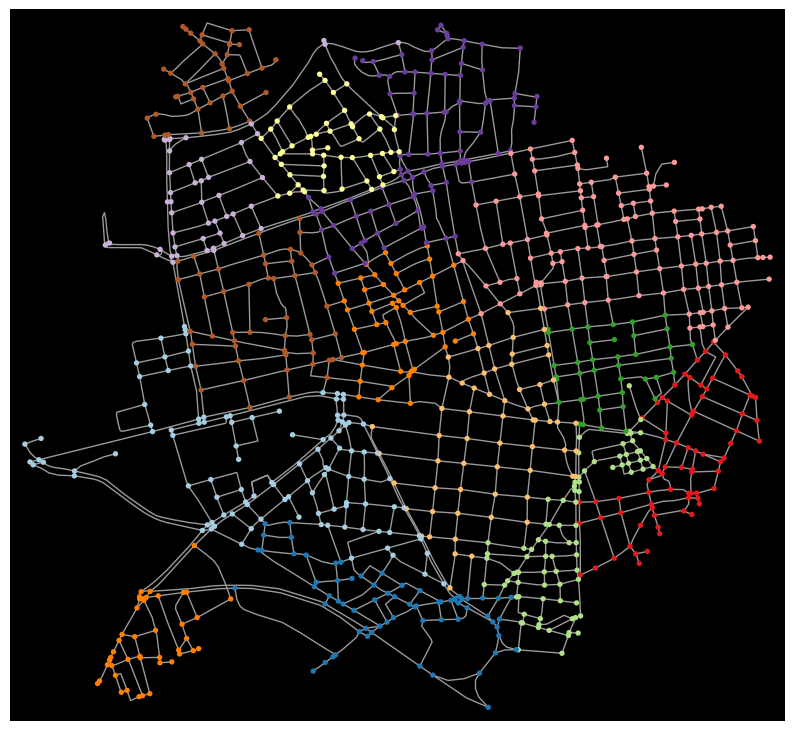

In [779]:
# Coloring for communities
nx.set_node_attributes(G_undirected, partition, name="attr_city")
nc = ox.plot.get_node_colors_by_attr(G_undirected, attr="attr_city", cmap='Paired')

fig, ax = ox.plot_graph(G_undirected, figsize=(10, 10), bgcolor="k", node_color=nc)
plt.pause(0.05)
plt.show()



The modularity value calculated for Gazi Street is 0.8574, indicating a strong community structure within the network. When the modularity value is close to 1, it suggests that the network is well-separated into communities, with dense connections within each community and sparse connections between communities. This result shows that Gazi Street has well-defined and well-separated communities, highlighting that the structure of the network is not random.

# Betweenness Centrality

Centrality measure that quantifies how often a node lies on the shortest path between other nodes in the network. A high betweenness centrality value indicates that a node serves as an important intermediary and controls the flow of information between other nodes. These nodes are considered as bridge points in the network and play a critical role in the communication and spreading of information. Betweenness centrality is calculated using the following formula:

$$
C_B(v) = \sum_{s,t \in V, s \neq t \neq v} \frac{\sigma_{st}(v)}{\sigma_{st}}
$$

Where:
- $C_B(v)$ represents the betweenness centrality of node v,
- $\sigma_{st}$ is the total number of shortest paths between nodes s and t,
- $\sigma_{st}(v)$ is the number of shortest paths from s to t that pass through node v.

This metric is useful for identifying critical nodes in the network and plays an important role in understanding the structural features of the network.


In [783]:
# Calculate Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Retrieve Betweenness Centrality values
betweenness_values = list(betweenness_centrality.values())

# Statistical summary
betweenness_stats = {
    'Min': np.min(betweenness_values),
    '1st Quartile': np.percentile(betweenness_values, 25),
    'Median': np.median(betweenness_values),
    '3rd Quartile': np.percentile(betweenness_values, 75),
    'Max': np.max(betweenness_values),
    'Mean': np.mean(betweenness_values),
}

# Print the summary statistics
print("Betweenness Centrality Statistics:")
for stat, value in betweenness_stats.items():
    print(f"{stat}: {value:.4f}")


Betweenness Centrality Statistics:
Min: 0.0000
1st Quartile: 0.0045
Median: 0.0111
3rd Quartile: 0.0277
Max: 0.2694
Mean: 0.0208


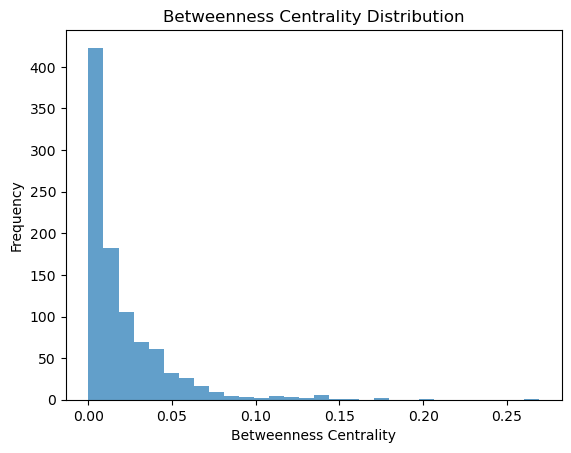

In [784]:

# Plot the distribution of betweenness centrality values
plt.hist(betweenness_values, bins=30, alpha=0.7)
plt.title('Betweenness Centrality Distribution')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.show()


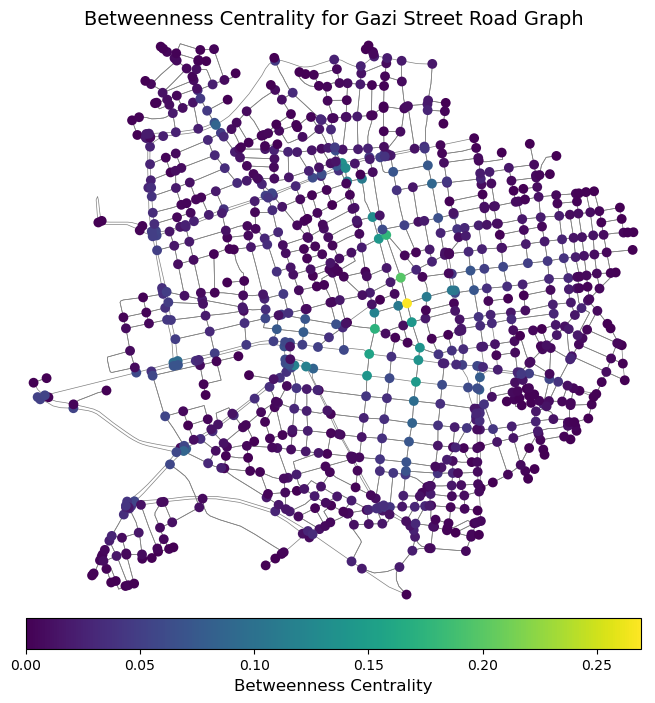

In [785]:

# Determine the node colors based on betweenness centrality values
node_colors = [betweenness_centrality[node] for node in G.nodes()]

# Set up the figure size
fig, ax = plt.subplots(figsize=(10, 8))  # We manually created the ax

# Normalize the values and choose a color palette (cmap)
norm = mpl.colors.Normalize(vmin=min(betweenness_values), vmax=max(betweenness_values))
cmap = mpl.cm.viridis  # Choose a color palette with green tones

# Plot the network graph
ox.plot_graph(G, node_color=node_colors, node_size=50, edge_color="gray", edge_linewidth=0.5, ax=ax, show=False)

# Add a colorbar
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.05, pad=0.02)
cbar.set_label("Betweenness Centrality", fontsize=12)

# Set the title
plt.title("Betweenness Centrality for Gazi Street Road Graph", fontsize=14)

# Display the plot
plt.show()


According to the Betweenness Centrality statistics:

- **Minimum (0.0000):** Some nodes do not mediate any communication in the network, meaning these nodes do not play an important role in the information flow of the network.

- **1st Quartile (0.0033) and Median (0.0092):** Most nodes have a low betweenness centrality value, meaning most nodes do not play a role in directing the information flow in the network.

- **3rd Quartile (0.0223):** Some nodes have a higher betweenness centrality value, and these nodes function as important bridges between different parts of the network.

- **Maximum (0.2335):** The highest value indicates that there is a highly central node in the network, and this node mediates communication between many other nodes.

- **Mean (0.0187):** Overall, most nodes in the network have a low betweenness centrality value, meaning only a few nodes provide significant connections, while most nodes do not play this role.


##  PageRank Centrality

PageRank assigns a score to each node based on the number and quality of the connections it receives (or incoming links). The main idea is that a node that receives connections from many important nodes is also important itself.

The PageRank for a node \( v \) can be calculated as:

$$
PR(v) = \frac{1 - d}{N} + d \sum_{u \in \text{In}(v)} \frac{PR(u)}{L(u)}
$$

Where:
- \( PR(v) \) is the PageRank of node \( v \),
- \( d \) is the damping factor (usually set to 0.85),
- \( N \) is the total number of nodes in the network,
- \( \text{In}(v) \) is the set of nodes that point to \( v \),
- \( L(u) \) is the number of outgoing links from node \( u \) (i.e., the degree of node \( u \)).

This formula represents the recursive calculation of PageRank, where each node's importance is influenced by the importance of the nodes linking to it.


In [789]:
# Calculate PageRank centrality
pagerank_centrality = nx.pagerank(G, alpha=0.85)

print(len(G))

# Display the PageRank values
#for node, pr in pagerank_centrality.items():
    #print(f"Node {node}: PageRank = {pr:.4f}")





955


In [790]:
top_5_pagerank = sorted(pagerank_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

print("\nTop 5 nodes with highest PageRank:")
for node, pr in top_5_pagerank:
    print(f"Node {node}: PageRank = {pr:.4f}")


Top 5 nodes with highest PageRank:
Node 2203369869: PageRank = 0.0029
Node 2203369878: PageRank = 0.0026
Node 2203347965: PageRank = 0.0019
Node 2204628236: PageRank = 0.0019
Node 2204369446: PageRank = 0.0018


In [792]:
node_id = 2203369869

pagerank_value = pagerank_centrality[node_id]

neighbors = list(G.neighbors(node_id))

degree = G.degree(node_id)

print(f"Node {node_id} Information:")
print(f"PageRank Value: {pagerank_value:.4f}")
print(f"Neighbors: {neighbors}")
print(f"Degree: {degree}")


Node 2203369869 Information:
PageRank Value: 0.0029
Neighbors: [2203369878]
Degree: 3


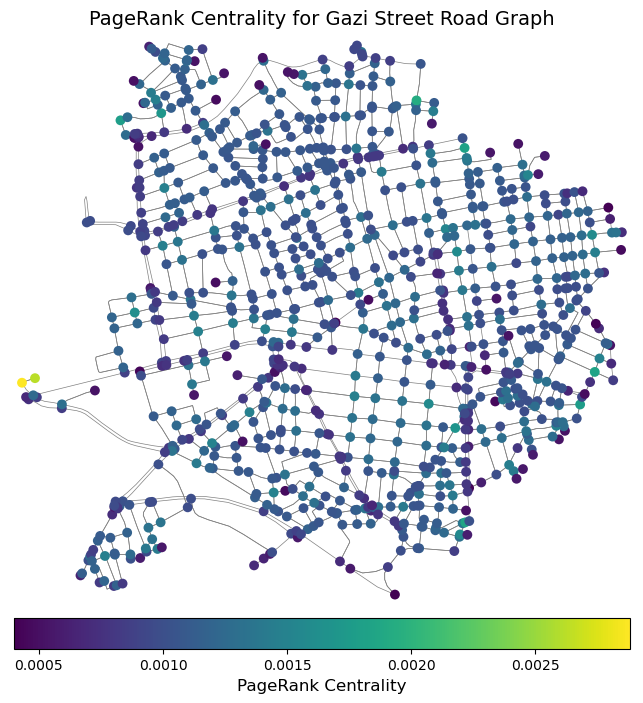

In [793]:
# Determine the node colors based on PageRank centrality values
node_colors = [pagerank_centrality[node] for node in G.nodes()]

,
fig, ax = plt.subplots(figsize=(10, 8))  


norm = mpl.colors.Normalize(vmin=min(pagerank_centrality.values()), vmax=max(pagerank_centrality.values()))
cmap = mpl.cm.viridis  


ox.plot_graph(G, node_color=node_colors, node_size=50, edge_color="gray", edge_linewidth=0.5, ax=ax, show=False)

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.05, pad=0.02)
cbar.set_label("PageRank Centrality", fontsize=12)

# Set the title
plt.title("PageRank Centrality for Gazi Street Road Graph", fontsize=14)

# Display the plot
plt.show()


The PageRank centrality appears to be concentrated at the edge nodes of the graph, which is different from what is typically expected. Normally, the most critical connection points should be in the center, but here, some peripheral nodes have excessively high values. This situation suggests that there might be missing connections, routing errors, or an uneven distribution of weights in the PageRank calculation. To improve the accuracy of the analysis, it would be helpful to compare with other centrality measures and validate the network structure.

---